In [33]:
import sys
import numpy as np
import scipy.special as sps
from tqdm import tqdm_notebook
import pickle
import pandas as pd
import plotly
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import time
import init as z
import update_params as zz
import helpers as hp
import healthcare_params as hcp

sns.set(rc={'figure.figsize':(11, 4)})

## definitions
z.R0_type = 0 # 0 = normal, 1 = low, 2 = high
z.R0 = 2.2
out_filename_root,fig_rootname,stat_rootname=hp.setup_paths(z.R0_type)

filename_pct = "SIR_pct.pickle"
filename_raw = "SIR_raw.pickle"
out_filename = "SIR.pickle"

# setup paths
out_filename = out_filename_root+"/"+out_filename

pct_SIR = []
alpha_vec = []
pct_SIR_S = []
pct_SIR_I = []
pct_SIR_R = []
abs_SIR_S = []
abs_SIR_I = []
abs_SIR_R = []
pct_SIR_IR = []
abs_SIR_IR = []
pop_size = z.pop_N.sum()

def load_organise_data(filename,legext=""):
    with open(filename,'rb') as fid:
        pct_SIR,raw_SIR,alpha_vec = pickle.load(fid)
    fid.close()
    num = len(alpha_vec)
    leg_full = []
    leg_full_IR = []  
    for idx in range(num):
        pct_SIR_I.append(pct_SIR[idx].inf) 
        pct_SIR_S.append(pct_SIR[idx].sus) 
        pct_SIR_R.append(pct_SIR[idx].rec) 
        pct_SIR_IR.append(pct_SIR[idx].inf)
        pct_SIR_IR.append(pct_SIR[idx].rec)
        abs_SIR_I.append(pop_size*pct_SIR[idx].inf)
        abs_SIR_S.append(pop_size*pct_SIR[idx].sus) 
        abs_SIR_R.append(pop_size*pct_SIR[idx].rec)    
        abs_SIR_IR.append(pop_size*pct_SIR[idx].inf)
        abs_SIR_IR.append(pop_size*pct_SIR[idx].rec) 
        v = str(np.round(100*alpha_vec[idx])-1)
        leg_full.append(v+"%"+legext)
        leg_full_IR.append("I+"+v+"%"+legext)
        leg_full_IR.append("R+"+v+"%"+legext)
    return alpha_vec,num,leg_full,leg_full_IR

## load and organise data
alpha_vec,num,leg_full,leg_full_IR=load_organise_data(out_filename)
alpha_idx_high = num-1 # 100%
alpha_idx_med = num-6  # 75
alpha_idx_low = num-8  # 65
alpha_idx_vec = [0,alpha_idx_low,alpha_idx_med,alpha_idx_high]


##  definitions of plotting and saving functions
def set_fig_style():
    plt.rc('savefig',dpi=300)
    #plt.rc('title',weight='bold')
    plt.rc('axes',facecolor='white')
    plt.rc('grid',linestyle='-',color='gray',alpha=.15)
    
def plot_peaks(data,idx_arr,y_max,scale):
    leg_vec = []
    for idx in (idx_arr):
        plt.plot(x,scale*data[idx],alpha=.9)
        plt.xlim((0,z.simul_len))
        plt.ylim((0,y_max))
        leg_vec.append(str(100*int(alpha_vec[idx]*100)/100)+"%")
    plt.grid(True)    
    return leg_vec,plt
        
def cmp_cases(data,idx_arr,col_arr):
    leg_vec = []
    k=0
    for idx in (idx_arr):
        dat = pd.DataFrame({'Vsetky pripady':np.concatenate([np.array(reported_cases),abs_SIR_I[idx]]),
                   'Zachytene pripady':np.concatenate([[0,0,0,0,0],np.array(reported_cases),abs_SIR_I[idx][:-5]])})
        plt.plot(x,dat['Zachytene pripady'][0:z.simul_len],c=col_arr[k],alpha=1,linewidth=1)
        plt.plot(x,dat['Vsetky pripady'][0:z.simul_len],c=col_arr[k],alpha=1,linewidth=1,linestyle='-.')
        k+=1
        leg_vec.append("Rep, alpha = "+str(100*int(alpha_vec[idx]*100)/100+1)+"%")
        leg_vec.append("All, alpha = "+str(100*int(alpha_vec[idx]*100)/100+1)+"%")
    return leg_vec,plt
    
    
def plot_infect_growth(data,idx_arr,y_min,y_max,rel):
    leg_vec = []
    for idx in idx_arr:
        # y = data_arr[idx][:,1,:].sum(0)
        # y = sumlist(data_arr[idx])[1,:].sum(0)
        y = data[idx].to_numpy()
        if rel:
            plt.plot(x,100*(y[1:lastday]/y[0:lastday-1]-1),alpha=0.9,linewidth=2)
        else:
            plt.plot(x,(y[1:lastday]-y[0:lastday-1]),alpha=0.9,linewidth=2)
        plt.xlim((0,lastday))
        plt.ylim((y_min,y_max))
        leg_vec.append(str(100*int(alpha_vec[idx]*100)/100)+"%")
    plt.grid(True)
    return leg_vec,plt
        
def export_res(ext):
    pd.DataFrame(np.array(pct_SIR_S).transpose(),columns=leg_full).to_csv(stat_rootname+"/"+ext+"pct_S.csv")
    pd.DataFrame(np.array(pct_SIR_I).transpose(),columns=leg_full).to_csv(stat_rootname+"/"+ext+"pct_I.csv")
    pd.DataFrame(np.array(pct_SIR_R).transpose(),columns=leg_full).to_csv(stat_rootname+"/"+ext+"pct_R.csv")
    pd.DataFrame(np.array(abs_SIR_S).transpose(),columns=leg_full).to_csv(stat_rootname+"/"+ext+"abs_S.csv")
    pd.DataFrame(np.array(abs_SIR_I).transpose(),columns=leg_full).to_csv(stat_rootname+"/"+ext+"abs_I.csv")
    pd.DataFrame(np.array(abs_SIR_R).transpose(),columns=leg_full).to_csv(stat_rootname+"/"+ext+"abs_R.csv")
    pd.DataFrame(np.array(pct_SIR_IR).transpose(),columns=leg_full_IR).to_excel(stat_rootname+"/"+ext+"pct_IR.xlsx",engine='xlsxwriter')    
    pd.DataFrame(np.array(abs_SIR_IR).transpose(),columns=leg_full_IR).to_excel(stat_rootname+"/"+ext+"abs_IR.xlsx",engine='xlsxwriter')    
    #pd.DataFrame(np.concatenate([np.array(abs_SIR_I),np.array(abs_SIR_R)]).transpose(),
    #            columns=leg_full_IR).to_excel(stat_rootname+"/abs_IR.xlsx",engine='xlsxwriter')
    
## Plotting   

In [ ]:
# 1.A compare peaks (as a function of pop.mobility alpha), relative numbers, HIGH alpha
x = np.arange(1,z.simul_len+1)
idx_arr = np.arange(alpha_idx_vec[2],num)
set_fig_style()
plt.subplot(121)
leg,plt = plot_peaks(pct_SIR_I,idx_arr,8,100)
# plt.legend(leg)
plt.title("Porovnanie peaku infekcie podla mobility populacie (vratane neevidovanych), R0="+str(z.R0))
plt.xlabel("Dni")
plt.ylabel("Pomer nakazenych v populacii (%)")

#set_fig_style()
plt.subplot(122)
leg,plt = plot_peaks(pct_SIR_I,idx_arr,pop_size*0.08,pop_size)
plt.legend(leg)
#plt.title("Porovnanie peaku infekcie podla mobility populacie (vratane neevidovanych), R0="+str(z.R0))
plt.xlabel("Dni")
plt.ylabel("Pocet nakazenych")
plt.savefig(fig_rootname+"/peaks_alpha_high.png",dpi=300)
plt.close

In [ ]:
# 1.B compare peaks (as a function of pop.mobility alpha), absolute numbers, MEDIUM alpha
idx_arr = np.arange(alpha_idx_vec[1],alpha_idx_vec[2]+1)
set_fig_style()
plt.subplot(121)
leg,plt = plot_peaks(pct_SIR_I,idx_arr,1.5,100)
#plt.legend(leg)
plt.title("Porovnanie peaku infekcie podla mobility populacie (vratane neevidovanych), R0="+str(z.R0))
plt.xlabel("Dni")
plt.ylabel("Pomer nakazenych v populacii (%)")

plt.subplot(122)
leg,plt = plot_peaks(pct_SIR_I,idx_arr,pop_size*0.015,pop_size)
plt.legend(leg)
# plt.title("Porovnanie peaku infekcie podla mobility populacie (vratane neevidovanych), R0="+str(z.R0))
plt.xlabel("Dni")
plt.ylabel("Pocet nakazenych")
plt.savefig(fig_rootname+"/peaks_alpha_med.png",dpi=300)
plt.close

In [ ]:
# 1.C compare peaks (as a function of pop.mobility alpha), for small alpha, relative numbers, LOW alpha
x = np.arange(1,z.simul_len+1)
idx_arr = np.arange(alpha_idx_vec[0],alpha_idx_vec[1])
set_fig_style()
plt.subplot(121)
leg,plt = plot_peaks(pct_SIR_I,idx_arr,0.05,100)
#plt.legend(leg)
plt.title("Porovnanie peaku infekcie podla mobility populacie (vratane neevidovanych), R0="+str(z.R0))
plt.xlabel("Dni")
plt.ylabel("Pomer nakazenych v populacii (%)")

plt.subplot(122)
leg,plt = plot_peaks(pct_SIR_I,idx_arr,pop_size*0.0005,pop_size)
plt.legend(leg)
plt.xlabel("Dni")
plt.ylabel("Pocet nakazenych")
plt.savefig(fig_rootname+"/peaks_alpha_low.png",dpi=300)
plt.close

In [ ]:
## 2.A compare growth of infectious persons (absolute numbers, daily basis),HIGH alpha
idx_arr = np.arange(alpha_idx_vec[2],num)
lastday = 100
x = np.arange(1,lastday)
set_fig_style()
plt.subplot(121)
leg,plt=plot_infect_growth(abs_SIR_I,idx_arr,-1000,15000,rel=False)
plt.title("Denny narast/pokles poctu infikovanych")
plt.ylabel("Zmena stavu (pocet ludi)")
plt.xlabel("Dni")
# plt.legend(leg)
# plt.subplots_adjust(left=.155)

plt.subplot(122)
leg,plt=plot_infect_growth(abs_SIR_I,idx_arr,-0,15,rel=True)
plt.title("Denny narast/pokles poctu infikovanych")
plt.ylabel("Relativne zmeny (%)")
plt.xlabel("Dni")
plt.legend(leg)
# plt.subplots_adjust(left=.155)

plt.savefig(fig_rootname+"/infect_growth_alpha_high.png",dpi=300)
plt.close

In [ ]:
## 2.B compare growth of infectious persons (absolute numbers, daily basis),MEDIUM alpha
idx_arr = np.arange(alpha_idx_vec[1],alpha_idx_vec[2]+1)
x = np.arange(1,lastday)
set_fig_style()
plt.subplot(121)
leg,plt=plot_infect_growth(abs_SIR_I,idx_arr,-25,500,rel=False)
plt.title("Denny narast/pokles poctu infikovanych")
plt.ylabel("Zmena stavu (pocet ludi)")
plt.xlabel("Dni")
# plt.legend(leg)
# plt.subplots_adjust(left=.155)

plt.subplot(122)
leg,plt=plot_infect_growth(abs_SIR_I,idx_arr,-2,8,rel=True)
plt.title("Denny narast/pokles poctu infikovanych")
plt.ylabel("Relativne zmeny (%)")
plt.xlabel("Dni")
plt.legend(leg)
# plt.subplots_adjust(left=.155)

plt.savefig(fig_rootname+"/infect_growth_alpha_med.png",dpi=300)
plt.close

In [ ]:
filename_pct = "SIR_pct.pickle"
filename_raw = "SIR_raw.pickle"
out_filename = "SIR.pickle"

def load_organise_data_I(filename,legext=""):
    with open(filename,'rb') as fid:
        pct_SIR,raw_SIR,alpha_vec = pickle.load(fid)
    fid.close()
    num = len(alpha_vec)
    pct_I = []
    abs_I = []
    leg_I = []
    for idx in range(num):
        pct_I.append(pct_SIR[idx].inf) 
        abs_I.append(pop_size*pct_SIR[idx].inf) 
        v = str(np.round(100*alpha_vec[idx])-1)
        leg_I.append(v+"%"+legext)
    return pct_I,abs_I,leg_I

# medium
out_filename_root_med,fig_rootname_med,stat_rootname_med=hp.setup_paths(0)
pct_I_med,abs_I_med,leg_I_med=load_organise_data_I(out_filename_root+"/"+out_filename,"_med")

# low
out_filename_root_low,fig_rootname_low,stat_rootname_low=hp.setup_paths(1)
pct_I_low,abs_I_low,leg_I_low=load_organise_data_I(out_filename_root_low+"/"+out_filename,"_low")
print(out_filename_root_low+"/"+out_filename)

# high
out_filename_root_high,fig_rootname_high,stat_rootname_high=hp.setup_paths(2)
pct_I_high,abs_I_high,leg_I_high=load_organise_data_I(out_filename_root_high+"/"+out_filename,"_high")

collist = ['red','orange','green','blue','yellow','purple','teal']

def plot_peaks_cmp(idx_arr,y_grid_max,scale,fill=False,rel=True,colidx0=0):
    leg_vec = []
    j=0
    with sns.axes_style("darkgrid"):
        for idx in (idx_arr):
            if rel:
                y_med = np.array(scale*pct_I_med[idx],dtype=np.float64)
                y_min = np.array(scale*pct_I_low[idx],dtype=np.float64)
                y_max = np.array(scale*pct_I_high[idx],dtype=np.float64)
            else:
                y_med = np.array(abs_I_med[idx],dtype=np.float64)
                y_min = np.array(abs_I_low[idx],dtype=np.float64)
                y_max = np.array(abs_I_high[idx],dtype=np.float64)
            plt.plot(x,y_med,alpha=.9,color=collist[j+colidx0],linewidth=2)
            plt.plot(x,y_min,alpha=.5,color=collist[j+colidx0],linestyle='--')
            plt.plot(x,y_max,alpha=.5,color=collist[j+colidx0],linestyle='-.')
            if fill:
                plt.fill_between(x,y_min,y_max,alpha=.3,facecolor=collist[j+colidx0])
            plt.xlim((0,z.simul_len))
            plt.ylim((0,y_grid_max))
            leg_vec.append("R0 med, alpha "+str(round(100*int(alpha_vec[idx]*100)/100))+"%")
            leg_vec.append("R0 low, alpha "+str(round(100*int(alpha_vec[idx]*100)/100))+"%")
            leg_vec.append("R0 high, alpha "+str(round(100*int(alpha_vec[idx]*100)/100))+"%")
            j+=1
        plt.grid(True)    
    return leg_vec,plt

x = np.arange(1,z.simul_len+1)
idx_arr = [4,6,8,10]
set_fig_style()

plt.subplot(121)
leg,plt = plot_peaks_cmp(idx_arr,8,100,fill=False,rel=True)
plt.title("Porovnanie peaku infekcie podla mobility populacie a R0")
plt.xlabel("Dni")
plt.ylabel("Pomer nakazenych v populacii (%)")


plt.subplot(122)
leg,plt = plot_peaks_cmp(idx_arr,pop_size*0.08,pop_size,fill=False,rel=False)
plt.xlabel("Dni")
plt.ylabel("Pocet nakazenych")
plt.legend(leg,ncol=2)
plt.savefig(fig_rootname+"/peaks_high.png",dpi=300)
plt.close

./out/R0low/SIR.pickle


<function matplotlib.pyplot.close(fig=None)>

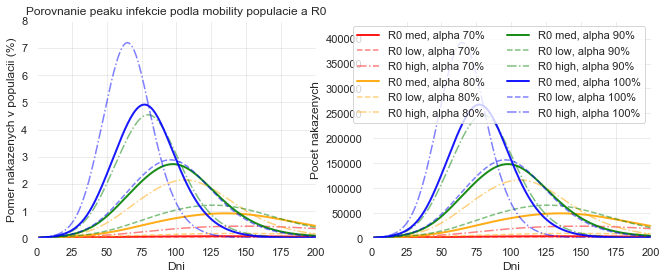

In [34]:
filename_pct = "SIR_pct.pickle"
filename_raw = "SIR_raw.pickle"
out_filename = "SIR.pickle"

def load_organise_data_I(filename,legext=""):
    with open(filename,'rb') as fid:
        pct_SIR,raw_SIR,alpha_vec = pickle.load(fid)
    fid.close()
    num = len(alpha_vec)
    pct_I = []
    abs_I = []
    leg_I = []
    for idx in range(num):
        pct_I.append(pct_SIR[idx].inf) 
        abs_I.append(pop_size*pct_SIR[idx].inf) 
        v = str(np.round(100*alpha_vec[idx])-1)
        leg_I.append(v+"%"+legext)
    return pct_I,abs_I,leg_I

# medium
out_filename_root_med,fig_rootname_med,stat_rootname_med=hp.setup_paths(0)
pct_I_med,abs_I_med,leg_I_med=load_organise_data_I(out_filename_root+"/"+out_filename,"_med")

# low
out_filename_root_low,fig_rootname_low,stat_rootname_low=hp.setup_paths(1)
pct_I_low,abs_I_low,leg_I_low=load_organise_data_I(out_filename_root_low+"/"+out_filename,"_low")
print(out_filename_root_low+"/"+out_filename)

# high
out_filename_root_high,fig_rootname_high,stat_rootname_high=hp.setup_paths(2)
pct_I_high,abs_I_high,leg_I_high=load_organise_data_I(out_filename_root_high+"/"+out_filename,"_high")

collist = ['red','orange','green','blue','yellow','purple','teal']

def plot_peaks_cmp(idx_arr,y_grid_max,scale,fill=False,rel=True,colidx0=0):
    leg_vec = []
    j=0
    with sns.axes_style("darkgrid"):
        for idx in (idx_arr):
            if rel:
                y_med = np.array(scale*pct_I_med[idx],dtype=np.float64)
                y_min = np.array(scale*pct_I_low[idx],dtype=np.float64)
                y_max = np.array(scale*pct_I_high[idx],dtype=np.float64)
            else:
                y_med = np.array(abs_I_med[idx],dtype=np.float64)
                y_min = np.array(abs_I_low[idx],dtype=np.float64)
                y_max = np.array(abs_I_high[idx],dtype=np.float64)
            plt.plot(x,y_med,alpha=.9,color=collist[j+colidx0],linewidth=2)
            plt.plot(x,y_min,alpha=.5,color=collist[j+colidx0],linestyle='--')
            plt.plot(x,y_max,alpha=.5,color=collist[j+colidx0],linestyle='-.')
            if fill:
                plt.fill_between(x,y_min,y_max,alpha=.3,facecolor=collist[j+colidx0])
            plt.xlim((0,z.simul_len))
            plt.ylim((0,y_grid_max))
            leg_vec.append("R0 med, alpha "+str(round(100*int(alpha_vec[idx]*100)/100))+"%")
            leg_vec.append("R0 low, alpha "+str(round(100*int(alpha_vec[idx]*100)/100))+"%")
            leg_vec.append("R0 high, alpha "+str(round(100*int(alpha_vec[idx]*100)/100))+"%")
            j+=1
        plt.grid(True)    
    return leg_vec,plt

x = np.arange(1,z.simul_len+1)
idx_arr = [4,6,8,10]
set_fig_style()

plt.subplot(121)
leg,plt = plot_peaks_cmp(idx_arr,8,100,fill=False,rel=True)
plt.title("Porovnanie peaku infekcie podla mobility populacie a R0")
plt.xlabel("Dni")
plt.ylabel("Pomer nakazenych v populacii (%)")


plt.subplot(122)
leg,plt = plot_peaks_cmp(idx_arr,pop_size*0.08,pop_size,fill=False,rel=False)
plt.xlabel("Dni")
plt.ylabel("Pocet nakazenych")
plt.legend(leg,ncol=2)
plt.savefig(fig_rootname+"/peaks_high.png",dpi=300)
plt.close

<function matplotlib.pyplot.close(fig=None)>

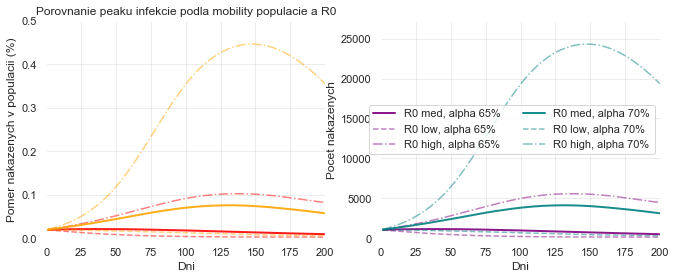

In [35]:
x = np.arange(1,z.simul_len+1)
idx_arr = [3,4]
set_fig_style()

plt.subplot(121)
leg,plt = plot_peaks_cmp(idx_arr,0.5,100,fill=False,rel=True)
plt.title("Porovnanie peaku infekcie podla mobility populacie a R0")
plt.xlabel("Dni")
plt.ylabel("Pomer nakazenych v populacii (%)")


plt.subplot(122)
leg,plt = plot_peaks_cmp(idx_arr,pop_size*0.005,pop_size,fill=False,rel=False,colidx0=5)
plt.xlabel("Dni")
plt.ylabel("Pocet nakazenych")
plt.legend(leg,ncol=2)
plt.savefig(fig_rootname+"/peaks_low.png",dpi=300)
plt.close

In [43]:
## saving stuff
# export all results
export_res("")

## reporting

# TAB 1: infected persons in selected days, with selected strategies (combinations of (R0,alpha))
sel_days = [10,20,30,40,50,60,80,100,125,150,175,195]
# we use R0 medium and R0 low and three different values of alpha-mobility
A = pd.DataFrame({'Dni':np.arange(0,z.simul_len),
                  'I_high':np.array(abs_I_med[alpha_idx_high]).transpose(),
                  'I_med':np.array(abs_I_med[alpha_idx_med]).transpose(),
                  'I_med_R0low':np.array(abs_I_low[alpha_idx_med]).transpose(),
                  'I_low':np.array(abs_I_med[alpha_idx_low]).transpose(),
                  'I_low_R0low':np.array(abs_I_med[alpha_idx_low]).transpose()})
A.columns = ['Pocet dni', 'Vysoka mobilita', 'Stredna mobilita',
            'Stredna mobilita,dalsie opatrenia','Nizka mobilita', 'Nizka mobilita, dalsie opatrenia']
A = A.iloc[sel_days]
A.to_excel('./stat/pocet_infikovanych.xlsx',engine='xlsxwriter',index=False)

# TAB 2: healthcare costs
# zatial pouzijeme IZP nastavenie parametrov
# pri costingu v podstate rataju s tym, ze kazdy infikovany je podchyteny/odreportovany systemom ....
# vysledky costingu su preto vyrazne nadstelene
repinf_inf_ratio,symp_repinf_ratio,hosp_symp_ratio,icu_hosp_ratio = hcp.get_healthcare_params(type=0)
# assumption: nizke R0, nizka mobilita (v nasom pripade polovicna, v pripade IZP len tretinova - neopodstatnene)
B = A.loc[:,['Pocet dni','Nizka mobilita, dalsie opatrenia']].copy()
B.columns = ['Pocet dni','Pocet vsetkych infikovanych']
B['Symptomaticki pacienti'] = B['Pocet vsetkych infikovanych']*repinf_inf_ratio*symp_repinf_ratio
B['Hospitalizacie'] = B['Symptomaticki pacienti']*hosp_symp_ratio
B['Intenzivna starostlivost'] = B['Hospitalizacie']*icu_hosp_ratio
B.to_excel('./stat/naklady.xlsx',engine='xlsxwriter',index=False)
                  

In [ ]:
                  
## 3 compare reported vs. all infected, HIGH alpha
x = np.arange(1,z.simul_len+1)
idx_arr = np.arange(alpha_idx_vec[2]+1,num,2)
col_arr = ['red','green','blue','orange']

set_fig_style()
plt.subplot(121)
leg,plt=cmp_cases(abs_SIR_I,idx_arr,col_arr)
plt.xlim(0,50)
plt.ylim(0,25000)
plt.xlabel('Dni')
plt.ylabel('Pocet')
plt.legend(leg)
plt.title('Vsetci vs.registrovani infikovani')

idx_arr = np.arange(alpha_idx_vec[2]-3,alpha_idx_vec[2],1)
set_fig_style()
plt.subplot(122)
leg,plt=cmp_cases(abs_SIR_I,idx_arr,col_arr)
plt.xlim(0,50)
plt.ylim(0,1500)
plt.xlabel('Dni')
plt.ylabel('Pocet')
plt.legend(leg)

plt.savefig(fig_rootname+"/known_unknown.png",dpi=300)
plt.close